# Import requirements

In [1]:
import sys                                                                      
import os
import pdb
import random
from scipy.io import loadmat
import torch
import numpy as np
import pickle
import configparser
import matplotlib.pyplot as plt
sys.path.append(os.path.expanduser("../src"))
import stats.kernels
import stats.svGPFA.svGPFAModelFactory
import stats.svGPFA.svEM
import plot.svGPFA.plotUtils

# Load data and initial values

In [2]:
simPrefix = "00000000_simulation"
trialToPlot = 0
optimParams = {"emMaxNIter":30, "eStepMaxNIter":100, "mStepModelParamsMaxNIter":100, "mStepKernelParamsMaxNIter":100, "mStepKernelParamsLR":1e-5, "mStepIndPointsMaxNIter":100}
initDataFilename = os.path.join("data/demo_PointProcess.mat")
spikeTimesFilename = \
    "results/{:s}_spikeTimes.pickle".format(simPrefix)
with open(spikeTimesFilename, "rb") as f: spikeTimes = pickle.load(f)

simConfigFilename = "results/{:s}_metaData.ini".format(simPrefix)
simConfig = configparser.ConfigParser()
simConfig.read(simConfigFilename)
nLatents = int(simConfig["latents_params"]["nLatents"])
nTrials = int(simConfig["spikes_params"]["nTrials"])

mat = loadmat(initDataFilename)
qMu0 = [torch.from_numpy(mat['q_mu0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSVec0 = [torch.from_numpy(mat['q_sqrt0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSDiag0 = [torch.from_numpy(mat['q_diag0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
Z0 = [torch.from_numpy(mat['Z0'][(i,0)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
C0 = torch.from_numpy(mat["C0"]).type(torch.DoubleTensor)
b0 = torch.from_numpy(mat["b0"]).type(torch.DoubleTensor).squeeze()                                                                                                                                                                                                                
legQuadPoints = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
legQuadWeights = torch.from_numpy(mat['wwQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
kernelNames = mat["kernelNames"]
hprs0 = mat["hprs0"]
testTimes = torch.from_numpy(mat['testTimes']).type(torch.DoubleTensor).squeeze()


# Create kernels

In [3]:
kernels = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernels[k] = stats.kernels.PeriodicKernel()
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernels[k] = stats.kernels.ExponentialQuadraticKernel()
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))            

# Create initial parameters

In [4]:
kernelsParams0 = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernelsParams0[k] = torch.tensor([1.0,
                                          float(hprs0[k,0][0]),
                                          float(hprs0[k,0][1])],
                                         dtype=torch.double)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernelsParams0[k] = torch.tensor([1.0,                              
                                          float(hprs0[k,0][0])],
                                         dtype=torch.double)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))
qUParams0 = {"qMu0": qMu0, "qSVec0": qSVec0, "qSDiag0": qSDiag0}                                                                                                                                                                                                                   
qHParams0 = {"C0": C0, "d0": b0}
kmsParams0 = {"kernelsParams0": kernelsParams0,
              "inducingPointsLocs0": Z0}
initialParams = {"svPosteriorOnIndPoints": qUParams0,
                 "kernelsMatricesStore": kmsParams0,
                 "svEmbedding": qHParams0}
quadParams = {"legQuadPoints": legQuadPoints,
              "legQuadWeights": legQuadWeights}


# Create model

In [5]:
model = stats.svGPFA.svGPFAModelFactory.SVGPFAModelFactory.buildModel(
    conditionalDist=stats.svGPFA.svGPFAModelFactory.PointProcess,
    linkFunction=stats.svGPFA.svGPFAModelFactory.ExponentialLink,
    embeddingType=stats.svGPFA.svGPFAModelFactory.LinearEmbedding,
    kernels=kernels)                                                            

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [6]:
svEM = stats.svGPFA.svEM.SVEM()
lowerBoundHist = svEM.maximize(model=model, measurements=spikeTimes,
                               initialParams=initialParams,
                               quadParams=quadParams,
                               optimParams=optimParams)                         

AttributeError: 'list' object has no attribute 'device'

# Plot lower bound history

<IPython.core.display.Javascript object>


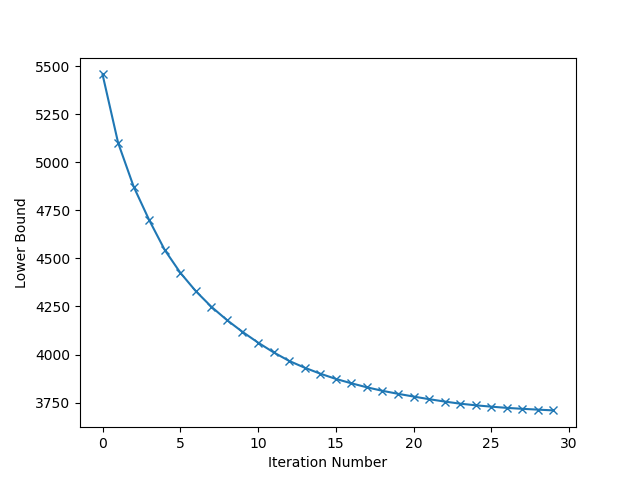

In [10]:
%matplotlib notebook
plot.svGPFA.plotUtils.plotLowerBoundHist(lowerBoundHist=lowerBoundHist)                                                  

# Predict latents at new times

In [11]:
testMuK, testVarK = model.predictLatents(newTimes=testTimes)                    

# Plot predicted latents for one trial

<IPython.core.display.Javascript object>


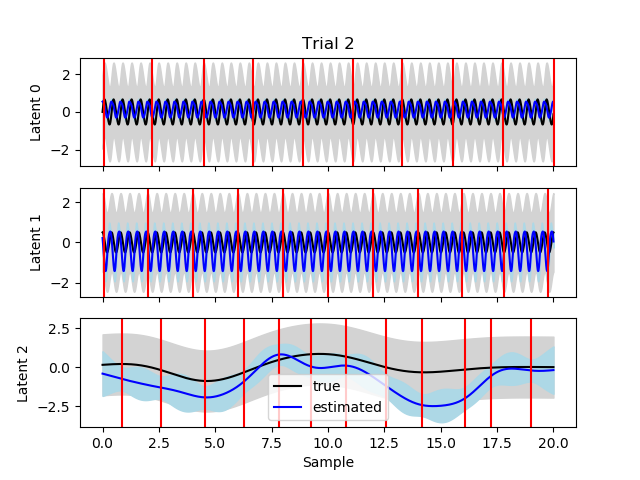

In [14]:
%matplotlib notebook
latentsFilename = "results/{:s}_latents.pickle".format(simPrefix)           
with open(latentsFilename, "rb") as f: trueLatentsSamples = pickle.load( f) 
trialToPlot=2
indPointsLocs = model.getIndPointsLocs()
plot.svGPFA.plotUtils.plotTrueAndEstimatedLatents(times=testTimes, muK=testMuK, varK=testVarK, indPointsLocs=indPointsLocs, trueLatents=trueLatentsSamples, trialToPlot=trialToPlot)